# Imports des modules et fonctions nécessaires

In [1]:
import os
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# Chargement et nettoyage des données

In [2]:
df_ACE = pd.read_csv(os.path.join(r"champs-elysees.csv"), sep=";")
df_Sts = pd.read_csv(os.path.join(r"Sts.csv"), sep=";")
df_convention = pd.read_csv(os.path.join(r"convention.csv"), sep=";")

dfs = [df_ACE, df_Sts, df_convention]

## Traitement des dates

In [3]:
def clean_date(date):
    date = re.sub('T', ' ', date)
    date=date[:-6]
    return date

for df in (df_ACE, df_Sts, df_convention):
    df['Date et heure de comptage'] = df['Date et heure de comptage'].apply(lambda s : clean_date(s))


# Format d'une série temporelle
for df in dfs:
    df['Date et heure de comptage']= pd.to_datetime(df["Date et heure de comptage"], format='%Y-%m-%d %H:%M:%S')

# Lignes rangées par ordre chronologique
for df in (df_ACE, df_Sts, df_convention):
    df.sort_values("Date et heure de comptage",inplace = True)
    df
    
# Nous indiquons que la série temporelle est indexée selon la date
df_ACE = df_ACE.set_index('Date et heure de comptage')
df_convention = df_convention.set_index('Date et heure de comptage')
df_Sts = df_Sts.set_index('Date et heure de comptage')

## Visualisation de l'un des DataFrames

In [5]:
df_ACE.head(2)

,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
Date et heure de comptage,,,,,,,,,,,,,,
2019-11-01 04:00:00,4264,AV_Champs_Elysees,746.0,10.98889,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
2019-11-01 05:00:00,4264,AV_Champs_Elysees,549.0,7.40722,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."


# Création de DF pour débit et taux d'occupation

In [7]:
data = pd.DataFrame()
data['debit'] = df_ACE['Débit horaire']
data['taux'] = df_ACE["Taux d'occupation"]
data = data.set_index(df_ACE.index)

## Gestion des valeurs manquantes

In [12]:
print(f'Il manquent {data.debit.isna().sum()} valeurs')

Il manquent 77 valeurs


# Filling missing values with rolling mean, window = 3h

In [14]:
def fill_with_AR(df, column):
    '''Fills missing values in column with rolling mean. Creates column "filled_debit" or "filled_taux"'''
    y = df[column].rolling(10, center=True, min_periods=1).mean()
    if column == 'debit':
        name = column
    else:
        name = 'taux'
    df['filled_'+ name] = y
    df['filled_'+ name].update(df[column])
    
    # Si plus de 10 NaN d'affilée, on remplit ce qui reste:
    df['filled_'+ name].fillna(method='ffill', inplace=True)

fill_with_AR(data, 'debit')
fill_with_AR(data, 'taux')   

In [15]:
print(f'Il manquent {data.filled_debit.isna().sum()} valeurs')

Il manquent 0 valeurs


# Visualisation : Moyenne mobile, fenêtre = 24h

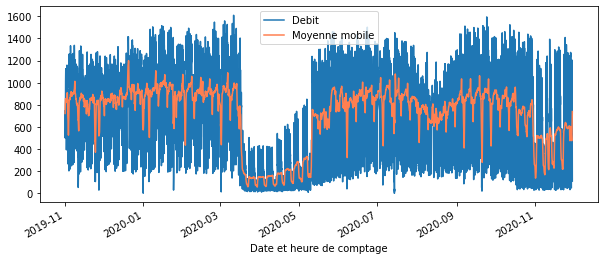

In [16]:
y = data.filled_debit.rolling(24, center=True, min_periods=1).mean()
data.filled_debit.plot(figsize=(10,4), label = 'Debit')
y.plot(figsize=(10,4), color='coral', label = 'Moyenne mobile')
plt.legend()
plt.show()

# Visualisation : Moyenne mobile, fenêtre = 24h

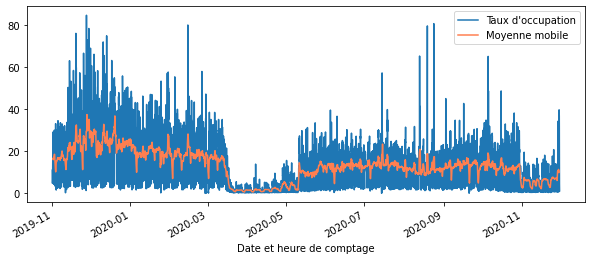

In [18]:
z = data.filled_taux.rolling(24, center=True).mean()
data.filled_taux.plot(figsize=(10,4), label = "Taux d'occupation")
z.plot(figsize=(10,4), color='coral', label = 'Moyenne mobile')
plt.legend()
plt.show()

# Modélisation des séries avec des modèles SARIMA 

## 1. Visualisation de la décomposition du débit

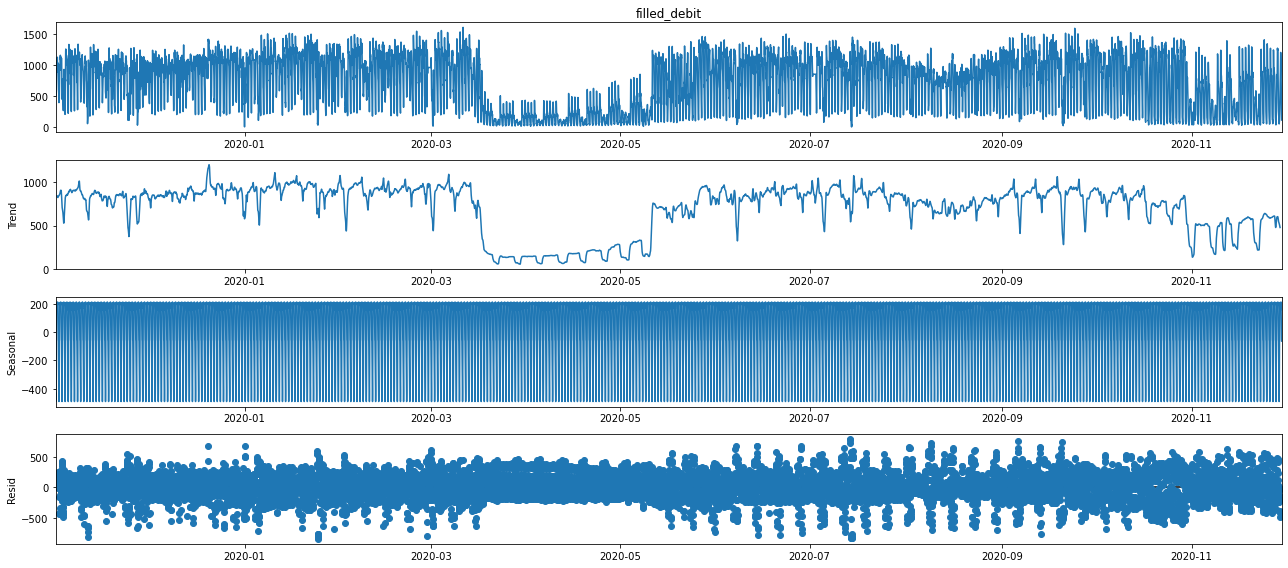

In [20]:
# Établissement de la fréquence de la série, valeurs mises à jour toutes les heures 
data = data.asfreq('H', method= 'ffill')
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data.filled_debit, model='additive')
fig = decomposition.plot()
plt.show()

## 2. Tentative avec un modèle SARIMA(2,1,4)(2,1,4,24)

Entraînement sur le mois de novembre, du 1/10 au 22/10. Prédictions du 22/10 au 27/10.

In [21]:
# Ordres du modèle
p,q,d=2,1,4
seasonal = (2,1,4,24)

# Création des dates nécessaires
a = datetime.strptime('2020-11-22 23:00:00', '%Y-%m-%d %H:%M:%S')
b = datetime.strptime('2020-11-27 23:00:00', '%Y-%m-%d %H:%M:%S')
X = data.loc['2020-11-01':'2020-11-22'].filled_debit

## 3. Model fitting

In [23]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning) # Permet d'éviter l'affichage des Warnings

s = time.time()
mod = sm.tsa.statespace.SARIMAX(X,order=(p,q,d),seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False)
model = mod.fit()
pred = model.predict(start=a,end=b)
e = time.time()
print(f"Temps d'éxecution: {e-s}")

Temps d'éxecution: 173.84637641906738


## 4. Plotting predictions

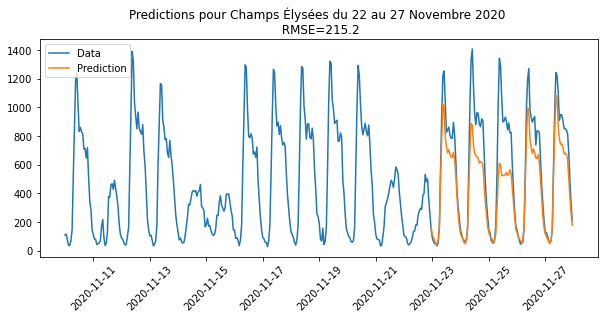

In [56]:
rmse = round(np.sqrt(mean_squared_error(data.loc['2020-11-22 23:00:00':'2020-11-27'].filled_debit, pred)),1)
plt.plot(data.loc['2020-11-10':'2020-11-27'].filled_debit, label='Data')
plt.plot(pred, label='Prediction')
plt.xticks(rotation=45)
plt.title(f'Predictions pour Champs Élysées du 22 au 27 Novembre 2020 \n RMSE={rmse}')
plt.legend()
plt.show()

# 5. Grid search of parameters

In [20]:
p,q = range(1,5),range(1,6)
d, d2 = range(1,4), range(1,4)
p2, q2 = range(1,5), range(1,5)
s = range(24,25)
pdq = list(itertools.product(p, d, q))
p2d2q2 = list(itertools.product(p2, d2, q2, s))

## Grid search

In [26]:
s = time.time()
aic_values, bic_values, total_rmse_values, test_rmse_values= {}, {}, {}, {}

for param in tqdm(pdq):
    for param_seasonal in p2d2q2:
        try:
            # Création du modèle
            mod = sm.tsa.statespace.SARIMAX(X,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            
            # Calculs AIC et BIC
            aic_score = round(results.aic,1)
            bic_score = round(results.bic,1)
            
            # Dates à considérer
            total_debut = datetime.strptime('2020-11-01 00:00:00', '%Y-%m-%d %H:%M:%S')
            total_fin = datetime.strptime('2020-11-22 23:00:00', '%Y-%m-%d %H:%M:%S')
            test_debut = datetime.strptime('2020-11-22 23:00:00', '%Y-%m-%d %H:%M:%S')
            test_fin = datetime.strptime('2020-11-27 23:00:00', '%Y-%m-%d %H:%M:%S')
            
            # Calcul des RMSE sur tout le mois de Novembre et sur la dernière semaine
            total_rmse = round(np.sqrt(mean_squared_error(data.loc['2020-11-22 23:00:00':'2020-11-27'].filled_debit, results.predict(start=test_debut,end=test_fin))),1)
            test_rmse = round(np.sqrt(mean_squared_error(data.loc['2020-11-22 23:00:00':'2020-11-27'].filled_debit, results.predict(start=test_debut,end=test_fin))),1)
            
            # Rajout des valeurs 
            aic_values[str(param)+str(param_seasonal)] = aic_score
            bic_values[str(param)+str(param_seasonal)] = bic_score
            total_rmse_values[str(param)+str(param_seasonal)] = total_rmse
            test_rmse_values[str(param)+str(param_seasonal)] = test_rmse
            
        except: 
            continue
e = time.time()
print(f"Temps d'éxecution: {e-s}")

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  4%|███▏                                                                            | 1/25 [12:03<4:49:35, 723.97s/it]C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 48%|████████████████████████████████████▍                                       | 12/25 [4:08:23<5:11:40, 1438.53s/it]C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.p

C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 25/25 [12:11:25<00:00, 1755.41s/it]

43885.33338499069


# Exploration des résultats

In [57]:
MOD,AIC,BIC,TOTAL_RMSE,TEST_RMSE = [],[],[],[],[]
for mod in aic_values.keys():
    # Obtention des valeurs
    aic_score = aic_values[mod]
    bic_score = bic_values[mod]
    total_rmse = total_rmse_values[mod]
    test_rmse = test_rmse_values[mod]
    # Report des données dans les listes   
    MOD.append(mod)
    AIC.append(aic_score)
    BIC.append(bic_score)
    TOTAL_RMSE.append(total_rmse)
    TEST_RMSE.append(test_rmse)

# Création de DataFrame
model_results = pd.DataFrame()
model_results['model'] = MOD
model_results['aic'] = AIC
model_results['bic'] = BIC
model_results['total_rmse'] = TOTAL_RMSE
model_results['test_rmse'] = TEST_RMSE

# Sauvegarde des valeurs
model_results.to_csv('grid_search.csv')

NameError: name 'aic_values' is not defined

# Visualisation AIC et BIC

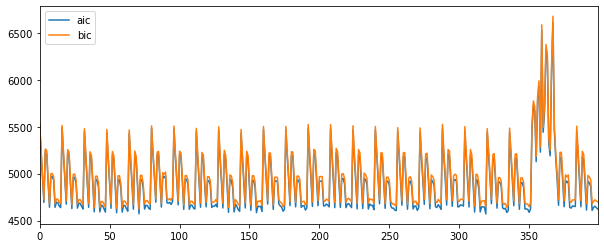

In [82]:
model_results.aic.plot(figsize=(10,4), label='AIC')
model_results.bic.plot(figsize=(10,4), label='BIC')
plt.legend()
plt.show()

# Visualisation RMSE Total (1/10 au 27/10) et Test (22/10 au 27/10)

<AxesSubplot:>

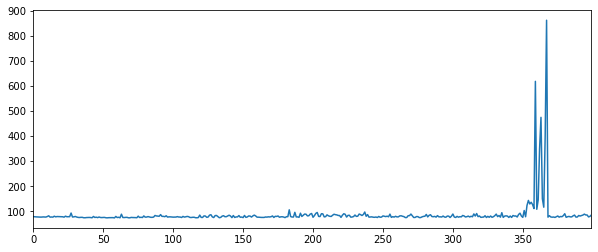

In [83]:
model_results.total_rmse.plot(figsize=(10,4), label= 'Total RMSE')
model_results.test_rmse.plot(figsize=(10,4), label='Test RMSE')
plt.legend()
plt.show()

# Modèles triés: par AIC croissant

In [58]:
sort_aic = model_results.sort_values(by = 'aic')
sort_aic.head(10)

,model,aic,bic,rmse
319,"(4, 1, 5)(4, 1, 4, 24)",4571.447240,4643.338545,80.727282
71,"(1, 1, 5)(2, 1, 4, 24)",4572.748539,4624.670038,74.554132
55,"(1, 1, 4)(2, 1, 4, 24)",4583.755179,4631.712604,74.125645
155,"(2, 1, 5)(3, 1, 4, 24)",4585.374943,4645.284364,80.271609
334,"(5, 1, 1)(4, 1, 3, 24)",4586.713876,4642.664205,75.969254


# Modèles triés: par BIC croissant

In [59]:
sort_bic = model_results.sort_values(by = 'bic')
sort_bic.head()

,model,aic,bic,rmse
71,"(1, 1, 5)(2, 1, 4, 24)",4572.748539,4624.670038,74.554132
55,"(1, 1, 4)(2, 1, 4, 24)",4583.755179,4631.712604,74.125645
39,"(1, 1, 3)(2, 1, 4, 24)",4594.153515,4638.141817,74.644922
135,"(2, 1, 4)(2, 1, 4, 24)",4588.494964,4640.448841,80.099571
43,"(1, 1, 3)(3, 1, 4, 24)",4593.161849,4641.149088,78.764987


# Modèles triés: par Total_RMSE croissant

In [60]:
sort_total_rmse = model_results.sort_values(by = 'total_rmse')
sort_total_rmse.head()

,model,aic,bic,rmse
58,"(1, 1, 4)(3, 1, 3, 24)",4851.437306,4900.090578,72.998582
53,"(1, 1, 4)(2, 1, 2, 24)",5149.253020,5190.345495,73.365021
69,"(1, 1, 5)(2, 1, 2, 24)",5138.230065,5183.407317,73.384977
52,"(1, 1, 4)(2, 1, 1, 24)",5199.648368,5236.711243,73.501150
68,"(1, 1, 5)(2, 1, 1, 24)",5199.796466,5240.977438,73.502423


# Modèles triés: par Test_RMSE croissant

In [ ]:
sort_test_rmse = model_results.sort_values(by = 'total_rmse')
sort_test_rmse.head()

# Visualisation pour un modèle particulier

In [73]:
a = datetime.strptime('2020-11-22 23:00:00', '%Y-%m-%d %H:%M:%S')
b = datetime.strptime('2020-11-27 23:00:00', '%Y-%m-%d %H:%M:%S')
X = data.loc['2020-11-01':'2020-11-22'].filled_debit

In [79]:
p,q,d = 1,1,4
seasonal = (3,1,3,24)
mod = sm.tsa.statespace.SARIMAX(X,order=(p,q,d),seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False)
model = mod.fit()
pred = model.predict(start=a,end=b)

In [132]:
def string_to_model(model):
    p = int(model[1])
    q = int(model[4])
    d = int(model[7])
    seasonal = (int(model[10]), int(model[13]), int(model[16]), int(model[19:21]))
    return p,q,d,seasonal

C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\carlo\Anaconda3\envs\datathon\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
C:\Users\carlo\

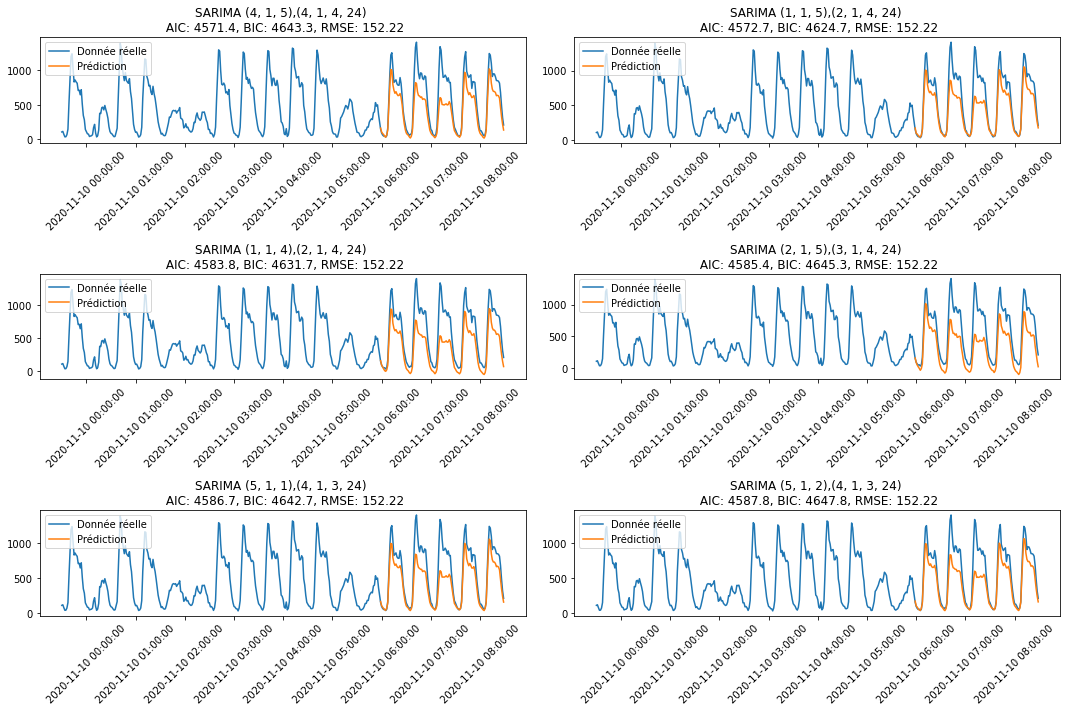

In [167]:
def exploration_sorted_results(sorted_df, output_file_name):
    ''' Permet d'afficher les meilleurs modèles triés selon l'une des métriques''' 
    '''sorted_df doit être dans {sort_aic, sort_bic, sort_total_rmse, sort_total}'''
    fig= plt.figure(figsize=(15,10))
    df = sorted_df
    for i in range(1,7):
        params = df.loc[df.index[i-1]].model
        p,q,d,seasonal = string_to_model(params)
        mod = sm.tsa.statespace.SARIMAX(X,order=(p,q,d),seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False)
        model = mod.fit()
        pred = model.predict(start=a,end=b)
        ax = fig.add_subplot(3,2,i)
        ax.plot(data.loc['2020-11-10':'2020-11-27'].filled_debit, label='Donnée réelle')
        ax.plot(pred, label='Prédiction')
        ax.legend()
        ax.set_title(f'SARIMA {(p,q,d)},{seasonal} \n AIC: {round(model.aic,1)}, BIC: {round(model.bic,1)}, RMSE: {round(np.sqrt(mean_squared_error(X, results.predict(start=f ,end=ff))),2)}')
        ax.set_xticklabels(data.loc['2020-11-10':'2020-11-27'].index, rotation = 45)
    fig.tight_layout()
    plt.savefig(output_file_name)
    fig.show()

## Exploration selon AIC

In [ ]:
exploration_sorted_results(sort_aic, 'aic.pdf')

## Exploration selon BIC

In [ ]:
exploration_sorted_results(sort_bic, 'bic.pdf')

## Exploration selon Total_RMSE

In [ ]:
exploration_sorted_results(sort_total_rmse, 'total_rmse.pdf')

## Exploration selon Test_RMSE

In [ ]:
exploration_sorted_results(sort_test_rmse, 'total_rmse.pdf')